In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")

import tdgl
import superscreen as sc

In [2]:
layer = tdgl.Layer(
    coherence_length=0.5, london_lambda=2, thickness=0.2, z0=0,
)
radius = 30
film = tdgl.Polygon(
    "film",
    points=tdgl.geometry.circle(radius, points=201),
    # points=tdgl.geometry.box(2 * radius, points_per_side=51),
)a
source = tdgl.Polygon(points=tdgl.geometry.box(0.1, 51, center=(-radius, 0)))
drain = source.scale(xfact=-1)
device = tdgl.Device(
    "box",
    layer=layer,
    film=film,
#     source_terminal=source,
#     drain_terminal=drain,
    length_units="um",
)

In [3]:
device.make_mesh(min_points=1500, optimesh_steps=100)

In [4]:
from tdgl.em import current_loop_vector_potential

pl_radius = 0.6
fc_radius = 2.5
z0 = 0.5
pl = sc.Polygon(points=sc.geometry.circle(pl_radius, points=201))
pl_points, pl_triangles = pl.make_mesh(min_points=1000, optimesh_steps=40)
pl_centroids = sc.fem.centroids(pl_points, pl_triangles)
pl_areas = sc.fem.areas(pl_points, pl_triangles)
pl_centroids = np.append(
    pl_centroids, z0 * np.ones_like(pl_centroids[:, :1]), axis=1
)

fc = sc.Polygon(points=sc.geometry.circle(fc_radius, points=201))

def applied_potential(x, y, z, *, fc_radius, fc_center, fc_current):
    
    loop_center = np.atleast_2d(fc_center)
    loop_radius = fc_radius
    loop_current = fc_current

    length_units = device.ureg(device.length_units)
    positions = (
        np.stack([x, y, z], axis=1) * length_units
    ).to("m").m
    loop_center = (loop_center * length_units).to("m").m
    loop_radius = (loop_radius * length_units).to("m").m
    potential = current_loop_vector_potential(
        positions,
        loop_center=loop_center,
        current=loop_current,
        loop_radius=loop_radius,
    )
    return potential.to(f"mT * {device.length_units}").m

In [5]:
# from tdgl.em import uniform_Bz_vector_potential

# ureg = device.ureg

# def applied_potential(x, y, z, field="1 uT"):
#     length_units = ureg(device.length_units)
#     positions = (
#         np.stack([x, y, z], axis=1) * length_units
#     ).to("m")
#     potential = uniform_Bz_vector_potential(positions, field)
#     return potential.to(f"mT * {device.length_units}").m

In [6]:
dt = 1e-2

solution = tdgl.solve(
    device,
    tdgl.Parameter(
        applied_potential,
        fc_radius=fc_radius,
        fc_center=(0, 0, z0),
        fc_current=8e-3,
    ),
#     tdgl.parameter.Parameter(applied_potential, field="50 uT"),
    "output2.h5",
    rtol=0,
    pinning_sites=0*10e-3,
    field_units="mT",
    gamma=10,
    dt=1e-2,
    skip=0,
    min_steps=None,
    max_steps=int(50 / dt),
    save_every=10,
    source_drain_current=0,
    include_screening=True,
)

Simulating: 100%|██████████| 5001/5001 [06:01<00:00, 13.84it/s]


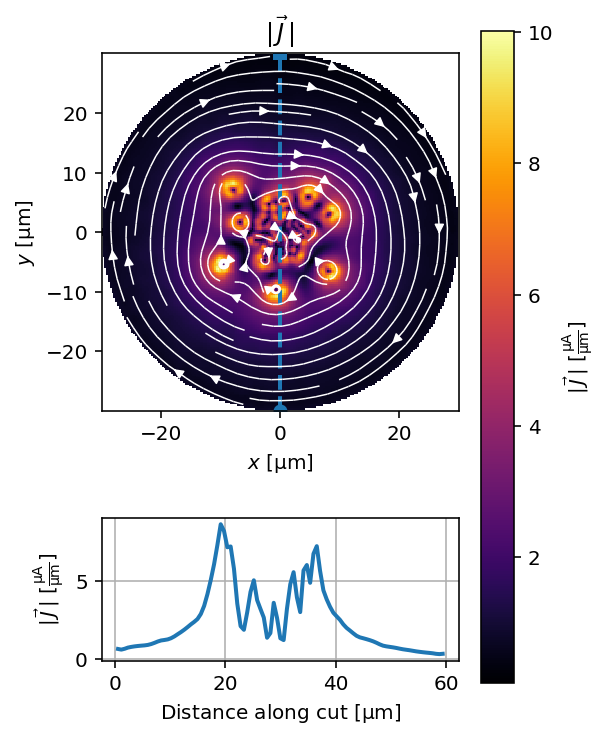

In [7]:
xs = np.linspace(-radius, radius, 101)
cross = [
    np.stack([0 * xs, xs], axis=1)
]

_ = solution.plot_currents(cross_section_coords=cross, figsize=(4, 6), streamplot=True)

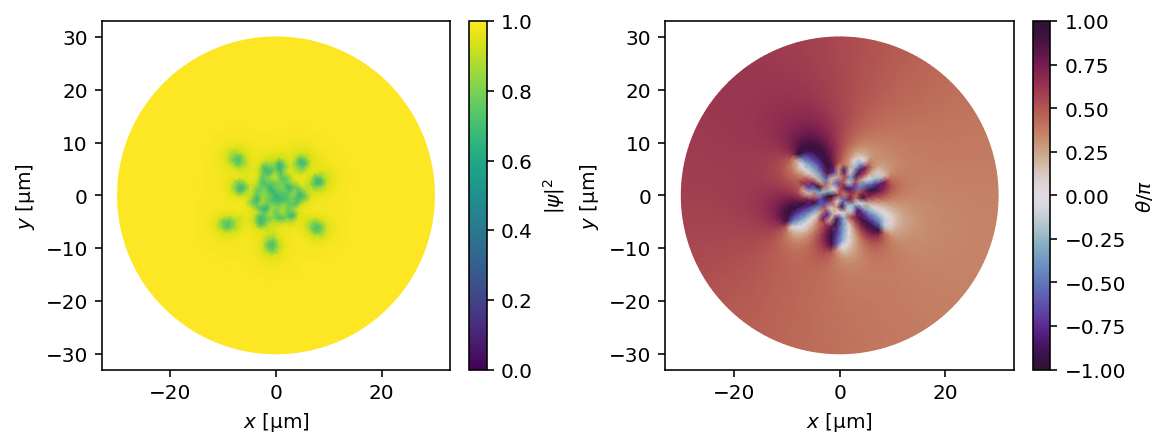

In [8]:
_ = solution.plot_order_parameter()

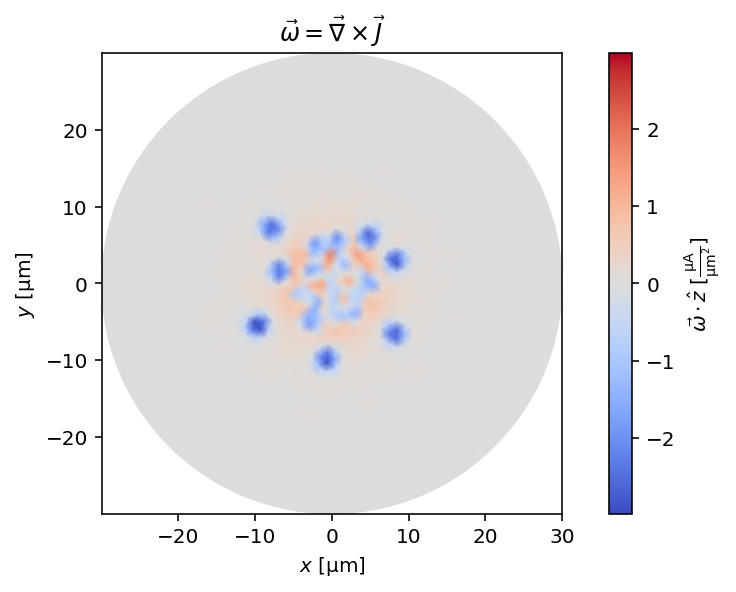

In [9]:
_ = solution.plot_vorticity()

In [ ]:
currents_rms = np.linspace(0.5, 5.5, 21)
thetas = 2 * np.pi * np.linspace(0, 2, 21, endpoint=False)
sin = np.sin(thetas)
cos = np.cos(thetas)
fields = {}

for current in currents_rms:
    fields[current] = []
    steps = 5_000
    save_every = 100
    seed = None
    for s in cos:
        solution = tdgl.solve(
            device,
            tdgl.Parameter(
                applied_potential,
                fc_radius=fc_radius,
                fc_center=(0, 0, z0),
                fc_current=1e-3 * current * s * np.sqrt(2),
            ),
            "output1.h5",
            pinning_sites=0,
            field_units="mT",
            gamma=1,
            dt=1e-2,
            skip=0,
            max_steps=steps,
            save_every=save_every,
            source_drain_current=0,
            seed_solution=seed,
            include_screening=True,
            rng_seed=1,
        )
        seed = solution
        steps = 500
        save_every = 10
        field = solution.field_at_position(
            pl_centroids,
            units="Phi_0 / um**2",
            with_units=False,
            return_sum=False,
        )
        fields[current].append(field)

In [ ]:
# flux_in_phase = np.array([np.sum(f.supercurrent * pl_areas) for f in fields])
# flux_oo_phase = np.array([np.sum(f.normal_current * pl_areas) for f in fields])

In [ ]:
flux = {}
for current, field in fields.items():
    flux[current] = np.array([np.sum(sum(f) * pl_areas) for f in field])

In [ ]:
lockin = []
ix = slice(11, None)
for current in currents_rms:
    phi = flux[current]
    lockin.append(np.sum(phi[ix] * np.exp(-1j * (thetas[ix] - 0 * np.pi/2))) / current / sin[ix].size)
#     lockin.append(phi[0] / current)
    
lockin = 1e3 * np.array(lockin)

In [ ]:
lockin

In [ ]:
fig, ax = plt.subplots()
ax.plot(currents_rms, lockin.real, "C0o-")
ax.plot(currents_rms, lockin.imag, "C1o-")

In [ ]:
solution.plot_order_parameter()

In [ ]:
# flux = flux_in_phase + flux_oo_phase

In [ ]:
X = np.sum(flux * sin)
Y = np.sum(flux * cos)

In [ ]:
1e3 * X / current, 1e3 * Y / current

In [ ]:
list(flux)

In [ ]:
fig, ax = plt.subplots()
colors = plt.get_cmap("inferno")(np.linspace(0, 1, len(flux)))
ofs = 0
for color, (current, phi) in zip(colors, list(flux.items())[:]):
    ax.plot(thetas[:], -phi[:] + ofs, ".-", color=color, label=f"{current:.2f}")
# ax.set_ylim(-6e-3, 6e-3)
bx = ax.twinx()
# bx.plot(thetas[:], cos[:], "C0o-")

In [ ]:
import h5py

In [ ]:
isinstance(h5py.Group, h5py.File)

In [ ]:
import os

In [ ]:
isinstance(str, os.PathLike)

In [ ]:
os.PathLike

In [ ]:
os.path.dirname(os.getcwd())

In [ ]:
str(np.int64)

In [ ]:
np.int64

In [26]:
import os
import json
from matplotlib.colors import LogNorm, SymLogNorm

In [446]:
base = "../results/63414739"
runs = sorted([f for f in os.listdir(base) if not f.startswith(".")], key=int)

In [447]:
currents = []
flux = []

for run in runs:
    path = os.path.join(base, run, "results.json")
    with open(path, "r") as f:
        data = json.load(f)
    args = data["args"] if "args" in data else data
    currents.append(np.array(data["I_fc"]))
    flux.append(np.array(data["flux"]))
    npoints = int(args["points_per_cycle"] * args["cycles"]) + 1
    thetas = np.linspace(0, 2 * np.pi * args["cycles"], npoints)
    
# currents = np.array(currents)
# flux = np.array(flux)

In [448]:
# fig, ax = plt.subplots()
# norm = SymLogNorm(linthresh=1e-2)
# im = ax.pcolormesh(1e3 * flux / currents, norm=norm, cmap="coolwarm")
# cbar = fig.colorbar(im, ax=ax)

In [449]:
lockin = []
ix = slice(25, None)
currents_rms = []
for current, phi in zip(currents, flux):
    ax.plot(thetas, phi, "o-")
    currents_rms.append(current.max() / np.sqrt(2))
    lockin.append(np.sum(phi[ix] * np.exp(-1j * (thetas[ix] - 0 * np.pi/2))) / currents_rms[-1] / current[ix].size)

lockin = 1e3 * np.array(lockin)

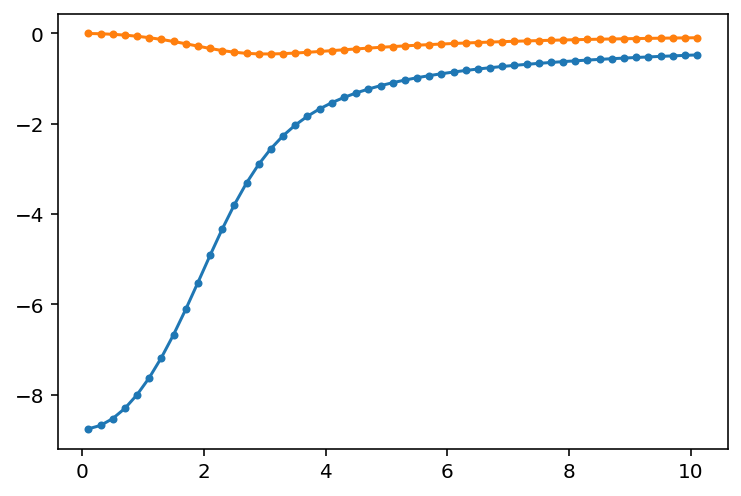

In [450]:
fig, ax = plt.subplots()
# bx = ax.twinx()
bx = ax
ax.plot(currents_rms, lockin.real, "C0.-")
bx.plot(currents_rms, lockin.imag, "C1.-")
# ax.plot(currents_rms, np.abs(lockin), "C0.-")
# bx.plot(currents_rms, np.angle(lockin) / np.pi, "C1.-")

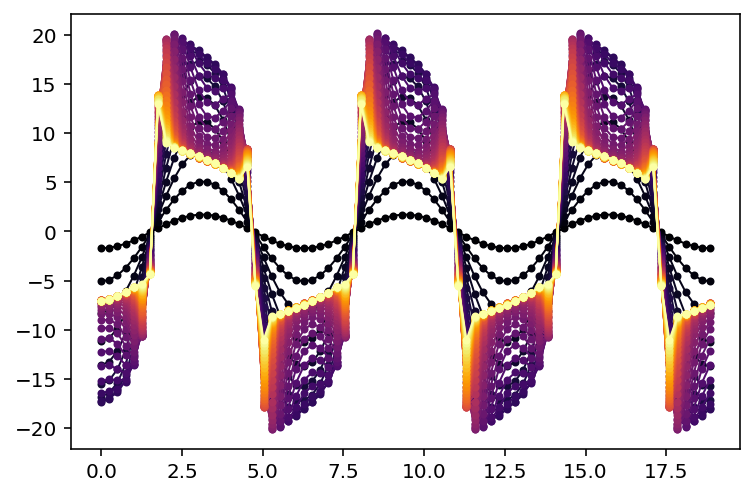

In [475]:
fig, ax = plt.subplots()
i = 20
# bx = ax.twinx()
colors = plt.get_cmap("inferno")(np.linspace(0, 1, len(flux)))

for i, phi in enumerate(flux[::1]):
    ax.plot(thetas, 1e3 * flux[i], ".-", color=colors[i], lw=1)
# bx.plot(thetas, -currents[i], "C1.-")
# ax.set_xlim(3 * np.pi / 2, 7 * np.pi / 2)

In [427]:
path = os.path.join(os.pardir, "results", "63362475", "results.json")
with open(path, "r") as f:
    data = json.load(f)

(-0.5, 10.5)

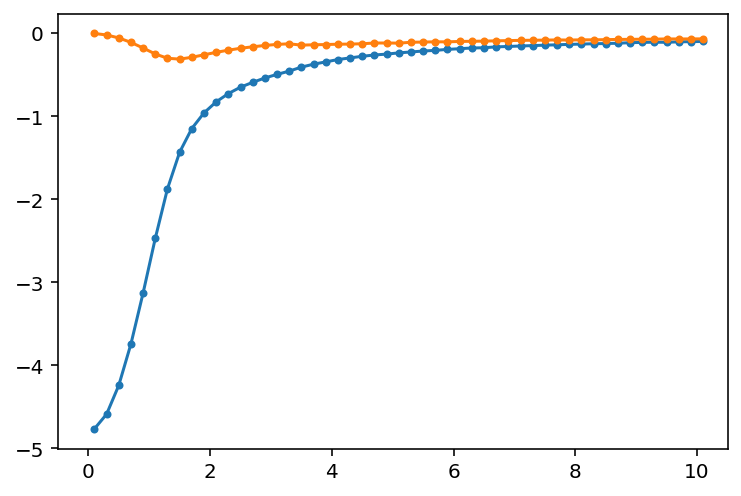

In [311]:
fig, ax = plt.subplots()
ax.plot(currents_rms, lockin.real, ".-")
ax.plot(currents_rms, lockin.imag, ".-")
ax.set_xlim(-0.5, 10.5)
# bx = ax.twinx()
# ax.plot(currents_rms, np.abs(lockin), "C0.-")
# bx.plot(currents_rms, np.angle(lockin) / np.pi, "C1.-")

In [428]:
data.keys()

dict_keys(['I_fc', 'args', 'flux', 'susc', 'timing'])

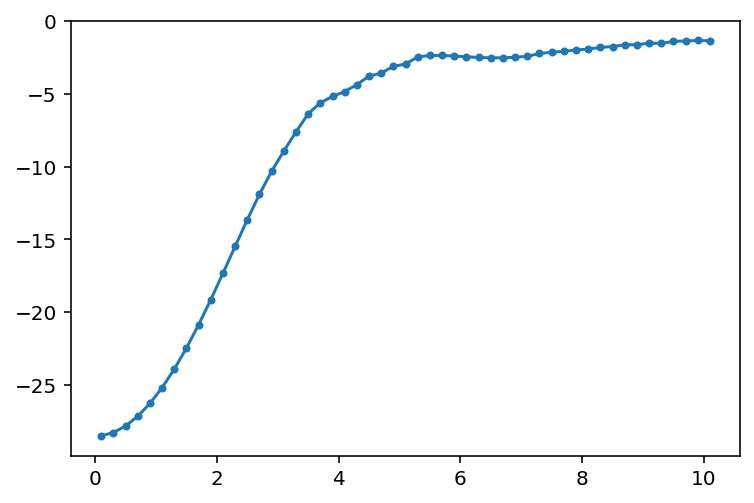

In [433]:
fig, ax = plt.subplots()

I_fc = np.array(data["I_fc"])
flux = np.array(data["flux"])
susc = 1e3 * flux / I_fc

ax.plot(I_fc, susc, ".-")